## Define basic functions and import packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as st
import statsmodels as sm
import pandas as pd
import matplotlib
import warnings
from astropy.io.fits import getdata
from PIL import Image

matplotlib.style.use('ggplot')

In [2]:
# From https://stackoverflow.com/a/37616966/2713263
def best_fit_distribution(data, distributions, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in distributions:
        print('Currently trying ' + distribution.name, end=', ')
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse
                
                print('Current best: ' + best_distribution.name)
        except Exception:
            pass

    return (best_distribution.name, best_params)

In [3]:
def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [4]:
def get_png_data(filename):
    """
    Get the PNG data for the given FITS file
    
    Args:
        filename: Path to the FITS file
    """
    data = getdata(filename)
    data = data.byteswap().newbyteorder()
    
    file = Image.fromarray(data)
    file = file.convert('L')  # black and white
    file.save('test.png')
    
    png_data = Image.open('test.png')
    png_data = np.array(png_data)
    
    return png_data

In [5]:
# Find best fit distribution
distributions = [st.weibull_min, st.laplace, st.expon, st.exponnorm, st.exponweib, st.cauchy, 
                st.dgamma, st.gamma, st.weibull_max, st.lognorm, st.chi2, st.pareto, st.rayleigh]

In [6]:
def get_best_distribution(filename, convert_png=True, dists=None, ax=None, plot=False, 
                          ret_pdf=True, bins=20, dist_name=True):
    """
    Gets the best fitting distribution among a set of distributions.
    
    Args:
    -----
    filename: The path to the FITS file
    convert_png: Convert to PNG before getting the distribution
    dists: The list of distributions to try fitting to. If None, uses predefined list
    ax: The plot axis object. Defaults to None
    plot: Plot the PDF
    ret_pdf: Computes the PDF
    dist_name: Returns the distribution name
    
    Returns:
    --------
    A 2-tuple (dist_str, pdf)
    """
    # Check error condition
    if ret_pdf == False and plot == True:
        raise ValueError('pdf must be True if plot is True.')
    
    # Get a list of distributions to try
    try_dists = None
    if dists is None:
        try_dists = distributions
    else:
        try_dists = dists
    
    # Get the data in the desired format
    data = None
    if convert_png:
        data = get_png_data(filename)
    else:
        data = getdata(filename)
        data = data.byteswap().newbyteorder()
    
    # Get the best fitting distribution
    data = pd.Series(data.ravel())
    best_fit_name, best_fit_paramms = best_fit_distribution(data, try_dists, 200, ax)
    best_dist = getattr(st, best_fit_name)
    
    # Get the PDF
    pdf = None
    if ret_pdf:
        pdf = make_pdf(best_dist, best_fit_paramms)
    
        # Plot the PDF if desired
        if plot:
            # Display
            plt.figure(figsize=(12,8))
            ax = pdf.plot(lw=2, label='PDF', legend=True)
            data.plot(kind='hist', bins=bins, density=True, alpha=0.5, label='Data', legend=True, ax=ax)
    
    dist_str = None
    if dist_name:
        param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
        param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_paramms)])
        dist_str = '{}({})'.format(best_fit_name, param_str)
    
    return (dist_str, pdf)

### Get stats about data

In [4]:
data = getdata('M13V20120711.fits')

In [5]:
data = data.byteswap().newbyteorder()

In [6]:
pd.DataFrame(data.ravel()).describe()

,0
count,904401.000000
mean,400.864868
std,737.239685
min,52.451576
25%,140.069305
50%,209.082565
75%,397.176208
max,29325.070312


In [7]:
len(np.unique(data))

885752

## Get best fit distribution

Currently trying weibull_min, Current best: weibull_min
Currently trying laplace, Current best: weibull_min
Currently trying expon, Current best: weibull_min
Currently trying exponnorm, Current best: exponnorm
Currently trying exponweib, Current best: exponweib
Currently trying cauchy, Current best: cauchy
Currently trying dgamma, Current best: cauchy
Currently trying gamma, Current best: cauchy
Currently trying weibull_max, Current best: cauchy
Currently trying lognorm, Current best: lognorm
Currently trying chi2, Current best: lognorm
Currently trying pareto, Current best: lognorm
Currently trying rayleigh, Current best: lognorm


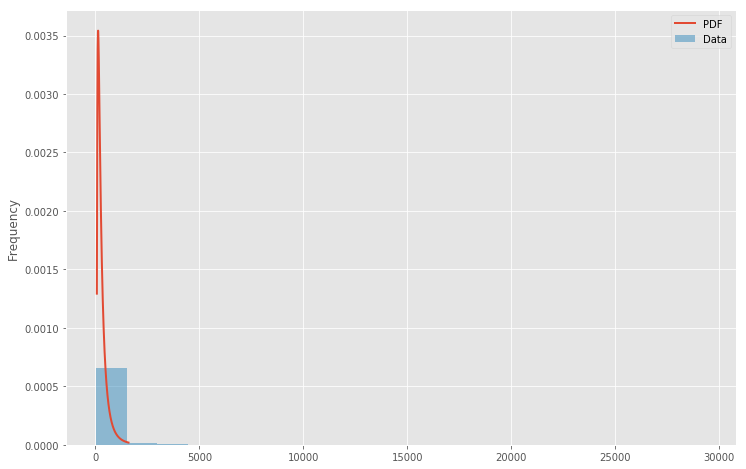

In [56]:
dist_str, pdf = get_best_distribution('M13V20120711.fits', convert_png=False, plot=True)

In [57]:
print(dist_str)

lognorm(s=0.91, loc=52.44, scale=187.39)


## Best-fit distribution for subtracted image

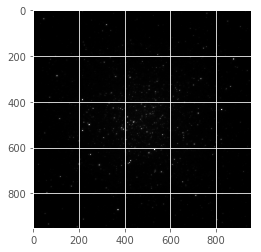

In [35]:
ref = getdata('M13Vreferencefr.fits')
plt.imshow(ref, cmap='gray')

In [36]:
ref = ref.byteswap().newbyteorder()
ref = pd.Series(ref.ravel())

In [37]:
sub = data - ref

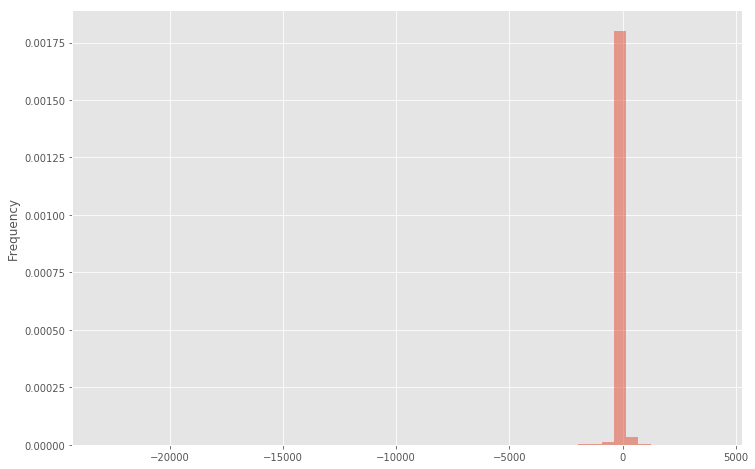

In [38]:
plt.figure(figsize=(12,8))
ax = sub.plot(kind='hist', bins=50, density=True, alpha=0.5)
# Save plot limits
subYLim = ax.get_ylim()

Currently trying  weibull_min
Currently trying  laplace
Currently trying  expon
Currently trying  exponnorm
Currently trying  exponweib
Currently trying  cauchy
Currently trying  dgamma
Currently trying  gamma
Currently trying  weibull_max
Currently trying  lognorm
Currently trying  chi2
Currently trying  pareto


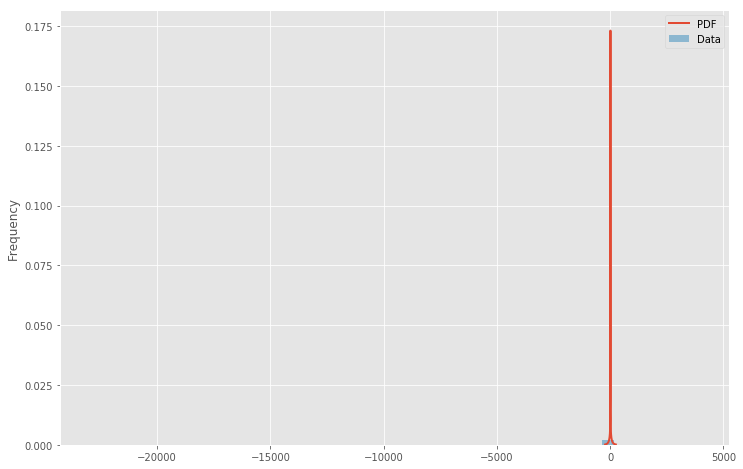

In [40]:
best_fit_name, best_fit_paramms = best_fit_distribution(sub, distributions, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(subYLim);
ax.set_ylabel('Frequency');

pdf = make_pdf(best_dist, best_fit_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True);
sub.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax);

In [41]:
param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)
print(dist_str)

dgamma(a=0.52, loc=17.33, scale=86.46)


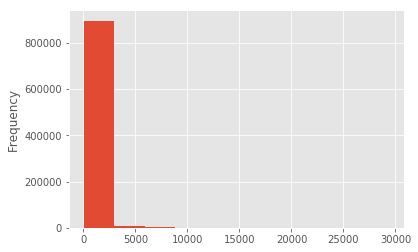

In [12]:
data.plot(kind='hist')  # FITS image histogram

## Using PNG

In [7]:
png_data = get_png_data('M13V20120711.fits')

In [8]:
png_data.shape

(951, 951)

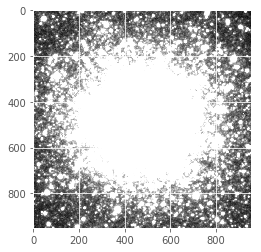

In [9]:
plt.imshow(png_data, cmap='gray')

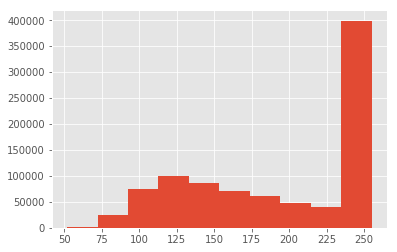

In [48]:
plt.hist(png_data.ravel());

Currently trying weibull_min, Current best: weibull_min
Currently trying laplace, Current best: weibull_min
Currently trying expon, Current best: weibull_min
Currently trying exponnorm, Current best: exponnorm
Currently trying exponweib, Current best: exponnorm
Currently trying cauchy, Current best: exponnorm
Currently trying dgamma, Current best: dgamma
Currently trying gamma, Current best: dgamma
Currently trying weibull_max, Current best: weibull_max
Currently trying lognorm, Current best: weibull_max
Currently trying chi2, Current best: weibull_max
Currently trying pareto, Current best: weibull_max
Currently trying rayleigh, Current best: weibull_max


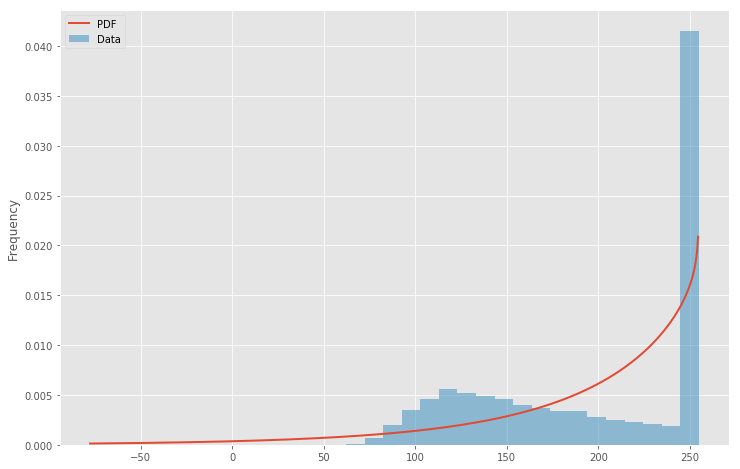

In [59]:
dist_str, pdf = get_best_distribution('M13V20120711.fits', plot=True)

### Now the reference image

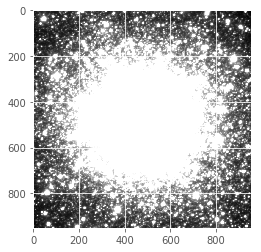

In [10]:
png_data2 = get_png_data('M13Vreferencefr.fits')
plt.imshow(png_data2, cmap='gray');

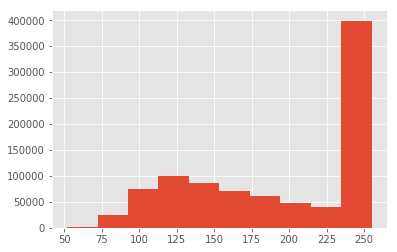

In [11]:
plt.hist(png_data.ravel());

In [12]:
series2 = pd.Series(png_data2.ravel())

(array([6.84490e+05, 1.46602e+05, 6.92000e+03, 1.46000e+02, 1.10000e+01,
        6.00000e+00, 1.00000e+01, 2.04000e+02, 4.68800e+03, 6.13240e+04]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

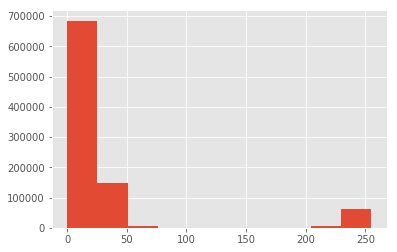

In [13]:
sub = pd.Series(png_data.ravel()) - series2
plt.hist(sub)

Currently trying weibull_min, Current best: weibull_min
Currently trying laplace, Current best: weibull_min
Currently trying expon, Current best: expon
Currently trying exponnorm, Current best: exponnorm
Currently trying exponweib, Current best: exponweib
Currently trying cauchy, Current best: cauchy
Currently trying dgamma, Current best: cauchy
Currently trying gamma, Current best: cauchy
Currently trying weibull_max, Current best: cauchy
Currently trying lognorm, Current best: cauchy
Currently trying chi2, Current best: cauchy
Currently trying pareto, Current best: cauchy
Currently trying rayleigh, Current best: cauchy


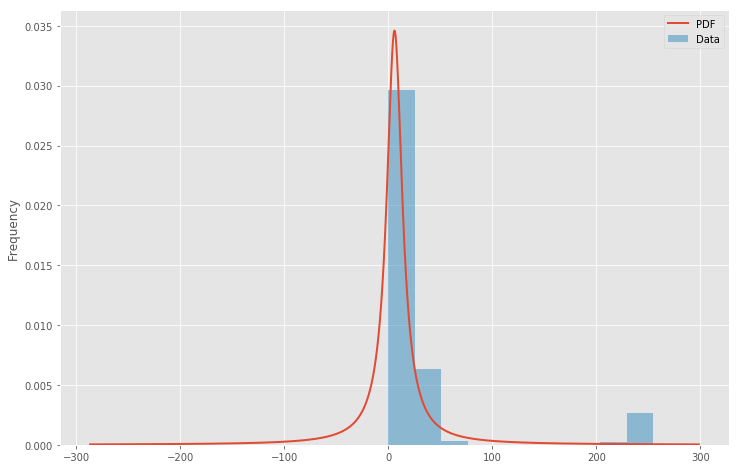

In [14]:
best_fit_name, best_fit_paramms = best_fit_distribution(sub, distributions, 20)
best_dist = getattr(st, best_fit_name)

pdf = make_pdf(best_dist, best_fit_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True);
sub.plot(kind='hist', density=True, alpha=0.5, label='Data', legend=True, ax=ax);

In [16]:
params = st.cauchy.fit(sub)

In [17]:
params

(5.929508599947418, 9.19941110358866)

In [19]:
from scipy import stats

In [34]:
logLik = -np.sum( stats.cauchy.logpdf(sub, loc=params[0], scale=params[1]) ) 

In [38]:
AIC = 2 * len(params) - 2 * np.log(logLik)
print(AIC)

-26.49639948228095


In [45]:
params = st.rayleigh.fit(sub)
args = params[:-2]
loc = params[-2]
scale = params[-1]
print(params)

logLik = -np.sum(st.rayleigh.logpdf(sub, loc=loc, scale=scale, *args))
AIC = 2 * len(params) - 2 * np.log(logLik)
print(AIC)

(-50.90199985022714, 71.70478968403172)
-26.76868348712793


In [44]:
params = st.weibull_min.fit(sub)
args = params[:-2]
loc = params[-2]
scale = params[-1]

logLik = np.sum(st.weibull_min.logpdf(sub, loc=loc, scale=scale, *args))  # - omitted
print(logLik)
AIC = 2 * len(params) - 2 * np.log(logLik)
print(AIC)

7118571.022838915
-25.556435128411866


## Try adding Rayleigh noise to the data
Because Rayleigh has the lowest AIC value

In [46]:
from PIL import Image

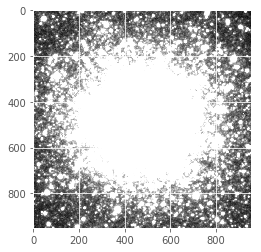

In [48]:
data = get_png_data('M13V20120711.fits')
plt.imshow(data, cmap='gray');

In [49]:
# Make sure scale refers to the one for Rayleigh before proceeding
print(scale)

71.70478968403172


In [58]:
noise = st.rayleigh.rvs(loc=loc, scale=scale, size=data.shape)

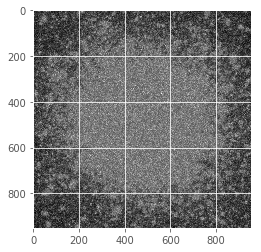

In [59]:
plt.imshow(data + noise, cmap='gray')

In [68]:
im = data + noise
im = Image.fromarray(im)
im = im.convert('L')
im.save('noisy.png')

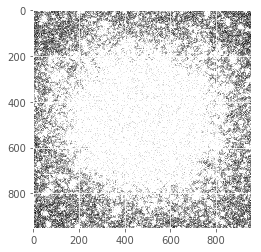

In [70]:
im = Image.open('noisy.png')
plt.imshow(np.array(im), cmap='gray');